# Introduction

This notebook will relate the parcellation of voxels into resting state networks with their parcellations based on the data-driven, RDoC, and DSM frameworks. The resting state atlas is the 7-network solution published by [Yeo *et al.* (2011)](https://www.physiology.org/doi/full/10.1152/jn.00338.2011) and distributed by [Freesurfer](https://surfer.nmr.mgh.harvard.edu/fswiki/CorticalParcellation_Yeo2011).

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
from nilearn import image, plotting

import sys
sys.path.append("..")
import utilities

import matplotlib.pyplot as plt
%matplotlib inline

# Load resting state networks

In [2]:
rs_dir = "Yeo_JNeurophysiol11_MNI152"
rs_file = "{}/Yeo2011_7Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz".format(rs_dir)

## Visualize the networks

In [3]:
def make_cmap(colors, position=None, bit=False, n_colors=256):
    '''
    http://schubert.atmos.colostate.edu/~cslocum/custom_cmap.html
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    import matplotlib as mpl
    import numpy as np
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap', cdict, n_colors)
    return cmap

In [4]:
cmap_df = pd.read_fwf("{}/Yeo2011_7Networks_ColorLUT.txt".format(rs_dir), index_col=0)
cmap_rgb = cmap_df.values[:,1:4] / 255.0
cmap_col = [(1,1,1)]*8 + [tuple(cmap_rgb[i,:]) for i in range(cmap_rgb.shape[0])]
cmap = make_cmap(cmap_col, n_colors=15)

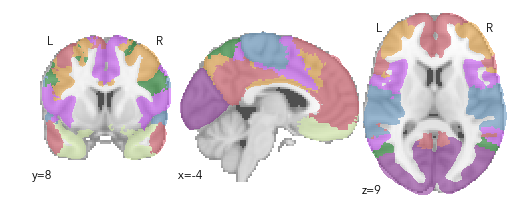

In [5]:
display = plotting.plot_stat_map(rs_file,
                                 cmap=cmap, alpha=0.5, 
                                 symmetric_cbar=True, colorbar=False,
                                 annotate=True, draw_cross=False)
display.savefig("figures/rs_xyz.png", dpi=250)
plotting.show()

## Extract one matrix per network

In [6]:
atlas = utilities.load_atlas()
atlas.shape

(182, 218, 182)

In [7]:
rs_img = image.load_img(rs_file)
rs_mat = image.resample_to_img(rs_img, atlas).get_data()[:,:,:,0]
rs_mat.shape

(182, 218, 182)

In [8]:
rs_mats = {}
for i in range(1,8):
    mat_i = rs_mat.copy()
    mat_i[mat_i != i] = 0.0
    mat_i[mat_i == i] = 1.0
    rs_mats[i] = mat_i

In [9]:
rs_vecs = np.empty((7, len(rs_mats[1].ravel())))
for i in range(7):
    rs_vecs[i,:] = rs_mats[i+1].ravel()

In [10]:
cmaps = [make_cmap([tuple(cmap_rgb[i])]*2, n_colors=2) for i in range(7)]

1


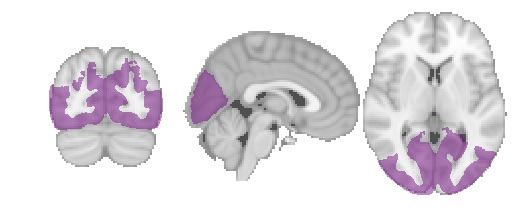

2


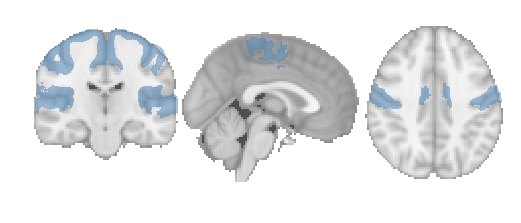

3


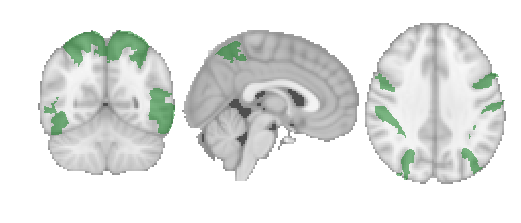

4


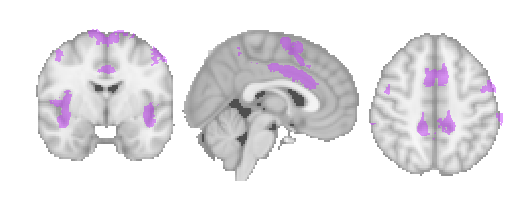

5


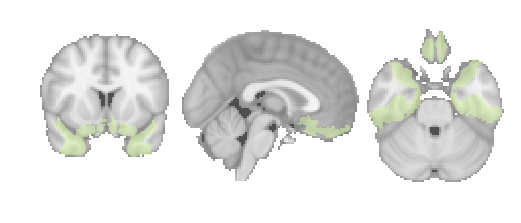

6


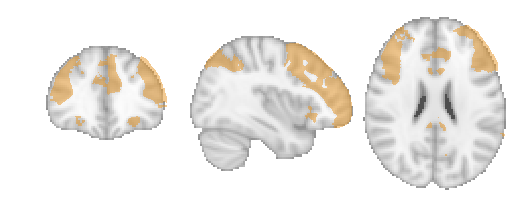

7


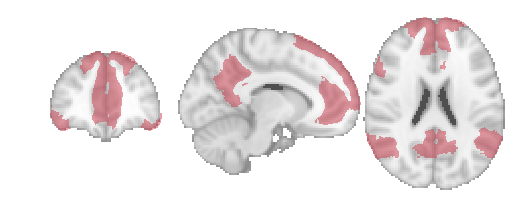

In [11]:
for i in range(1,8):
    print(i)
    plotting.plot_stat_map(image.new_img_like(atlas, rs_mats[i]), 
                           threshold=0.0, vmax=2.0,
                           cmap=cmaps[i-1], alpha=0.5, 
                           symmetric_cbar=True, colorbar=False,
                           annotate=False, draw_cross=False)
    plotting.show()

# Load our brain circuits

In [12]:
frameworks = ["data-driven", "rdoc", "dsm"]
suffixes = ["", "_opsim", "_opsim"]

In [13]:
def extract_circuit_mats(framework, suffix=""):
    _, circuits = utilities.load_framework(framework, suffix=suffix)
    framework_mats = {}
    mat = image.copy_img(atlas).get_data()
    for circuit, values in circuits.iteritems():
        circuit_mat = mat.copy()
        for i, value in enumerate(values):
            circuit_mat[circuit_mat == i+1] = value
        framework_mats[circuit] = circuit_mat
    return framework_mats

In [14]:
fw_mats = {fw: extract_circuit_mats(fw, suffix=s) for fw, s in zip(frameworks, suffixes)}

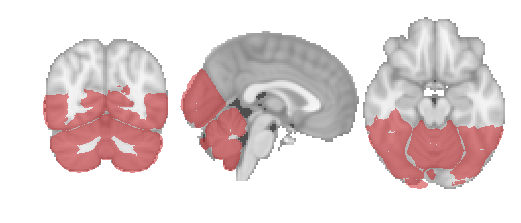

In [15]:
plotting.plot_stat_map(image.new_img_like(atlas, fw_mats["data-driven"]["VISION"]), 
                       threshold=0.0, vmax=2.0,
                       cmap="Reds", alpha=0.5, 
                       symmetric_cbar=True, colorbar=False,
                       annotate=False, draw_cross=False)
plotting.show()

# Relate circuits to resting state networks

## Vectorize framework data

In [16]:
from scipy.spatial.distance import cdist

In [17]:
circuits = {}
for fw, s in zip(frameworks, suffixes):
    l, c = utilities.load_framework(fw, suffix=s)
    circuits[fw] = list(c.columns)

In [18]:
fw_vecs = {}
for fw in frameworks:
    vecs = np.empty((len(circuits[fw]), len(fw_mats[fw][circuits[fw][0]].ravel())))
    for i, circuit in enumerate(circuits[fw]):
        vecs[i,:] = fw_mats[fw][circuit].ravel()
    fw_vecs[fw] = vecs

## Filter out voxels that are zero across all images

In [19]:
voxel_sums = np.sum(rs_vecs, axis=0)
for fw in frameworks:
    voxel_sums += np.sum(fw_vecs[fw], axis=0)
voxel_filter = voxel_sums > 0

In [20]:
rs_vecs.shape

(7, 7221032)

In [21]:
rs_vecs = rs_vecs[:,voxel_filter]
rs_vecs.shape

(7, 1419389)

In [22]:
for fw in frameworks:
    fw_vecs[fw] = fw_vecs[fw][:,voxel_filter]

## Compute observed values

In [23]:
def compute_similarities(framework):
    return 1.0 - cdist(fw_vecs[framework], rs_vecs, metric="cosine")

In [24]:
sims = {fw: pd.DataFrame(compute_similarities(fw), index=circuits[fw], columns=range(1,8)) for fw in frameworks}

In [25]:
sims["data-driven"]

,1,2,3,4,5,6,7
MEMORY,0.043015,0.000000,0.008795,0.000000,0.298373,0.013376,0.027838
REWARD,0.000000,0.000000,0.000000,0.000000,0.256405,0.000000,0.059009
REACTION_TIME,0.004462,0.032705,0.000000,0.222542,0.194665,0.267178,0.320981
MANIPULATION,0.092489,0.366794,0.373250,0.181800,0.000000,0.271394,0.247618
VISION,0.516179,0.000278,0.102794,0.016461,0.038197,0.032231,0.017398
LANGUAGE,0.000000,0.289297,0.000000,0.111930,0.111775,0.012048,0.225340


In [26]:
sims["rdoc"]

,1,2,3,4,5,6,7
NEGATIVE_VALENCE,0.021697,0.032975,0.007240,0.088265,0.480959,0.121381,0.182090
POSITIVE_VALENCE,0.000034,0.017794,0.000000,0.111634,0.204063,0.088926,0.128402
COGNITIVE_SYSTEMS,0.257525,0.184432,0.406710,0.125801,0.000000,0.295082,0.254847
SOCIAL_PROCESSES,0.127339,0.035994,0.095311,0.022159,0.444306,0.048766,0.234005
AROUSAL_REGULATION,0.031923,0.058490,0.008187,0.048363,0.376833,0.011169,0.076258
SENSORIMOTOR_SYSTEMS,0.025939,0.475114,0.259243,0.186705,0.000000,0.132104,0.097633


In [27]:
sims["dsm"]

,1,2,3,4,5,6,7
DEVELOPMENTAL,0.354906,0.143966,0.353224,0.105540,0.000262,0.149663,0.222099
PSYCHOTIC,0.000000,0.185389,0.091610,0.122442,0.000000,0.270992,0.151871
BIPOLAR,0.013356,0.005846,0.016130,0.069225,0.163829,0.160404,0.146735
DEPRESSIVE,0.024999,0.001191,0.000000,0.030587,0.098228,0.078611,0.113557
ANXIETY,0.012563,0.016566,0.000424,0.046633,0.263966,0.010252,0.048539
OBSESSIVE_COMPULSIVE,0.000000,0.070713,0.000000,0.108986,0.056585,0.016381,0.026000
TRAUMA_STRESSOR,0.018850,0.006637,0.000639,0.002384,0.189356,0.000005,0.029684
DISRUPTIVE,0.000034,0.000000,0.000000,0.026422,0.048975,0.098705,0.106238
SUBSTANCE,0.001895,0.019125,0.110544,0.000995,0.000091,0.004442,0.000000


## Compute null distributions

In [28]:
n_iter = 1000

In [29]:
def compute_similarities_null(framework, n_iter=1000):
    sim_null = np.empty((len(circuits[framework]), 7, n_iter))
    n_voxels = rs_vecs.shape[1]
    for n in range(n_iter):
        null = np.random.choice(range(n_voxels), size=n_voxels, replace=False)
        sim_null[:,:,n] = 1.0 - cdist(fw_vecs[framework], rs_vecs[:,null], metric="cosine")
        if n % (float(n_iter) / 10.0) == 0:
            print("\tIteration {}".format(n))
    return sim_null

In [30]:
fw_sim_null = {}
for framework in frameworks:
    print("Computing null for {}".format(framework))
    fw_sim_null[framework] = compute_similarities_null(framework, n_iter=n_iter)

Computing null for data-driven
	Iteration 0
	Iteration 100
	Iteration 200
	Iteration 300
	Iteration 400
	Iteration 500
	Iteration 600
	Iteration 700
	Iteration 800
	Iteration 900
Computing null for rdoc
	Iteration 0
	Iteration 100
	Iteration 200
	Iteration 300
	Iteration 400
	Iteration 500
	Iteration 600
	Iteration 700
	Iteration 800
	Iteration 900
Computing null for dsm
	Iteration 0
	Iteration 100
	Iteration 200
	Iteration 300
	Iteration 400
	Iteration 500
	Iteration 600
	Iteration 700
	Iteration 800
	Iteration 900


## Perform comparison tests

In [31]:
from statsmodels.stats import multitest

In [32]:
def compute_stats(framework):
    
    obs = sims[framework]
    
    p = pd.DataFrame(0.0, index=circuits[framework], columns=range(1,8))
    for i, dom in enumerate(circuits[framework]):  
        for j in range(7):
            dom_null = fw_sim_null[framework][i,j,:]
            p.loc[dom,j+1] = np.sum(dom_null > float(obs.loc[dom,j+1])) / float(n_iter)
    
    p_cor = multitest.multipletests(p.values.ravel(), method="fdr_bh")[1]
    p_cor = pd.DataFrame(p_cor.reshape((len(circuits[framework]), 7)), 
                                       index=circuits[framework], columns=range(1,8))
    
    stars = pd.DataFrame("", index=circuits[framework], columns=range(1,8))
    for dom in circuits[framework]:
        for j in range(1,8):
            for star, alpha in zip(["*", "**", "***"], [0.05, 0.01, 0.001]):
                if p_cor.loc[dom, j] < alpha:
                    stars.loc[dom, j] = star
    
    return {"OBSERVED": obs, "P": p, "P_COR": p_cor, "STARS": stars}

In [33]:
stats = {fw: compute_stats(fw) for fw in frameworks}

In [34]:
stats["data-driven"]["STARS"]

,1,2,3,4,5,6,7
MEMORY,,,,,***,,
REWARD,,,,,***,,***
REACTION_TIME,,,,***,***,***,***
MANIPULATION,,***,***,***,,***,***
VISION,***,,,,,,
LANGUAGE,,***,,***,***,,***


In [35]:
stats["rdoc"]["STARS"]

,1,2,3,4,5,6,7
NEGATIVE_VALENCE,,,,,***,,
POSITIVE_VALENCE,,,,***,***,,
COGNITIVE_SYSTEMS,***,,***,,,***,***
SOCIAL_PROCESSES,,,,,***,,***
AROUSAL_REGULATION,,,,,***,,
SENSORIMOTOR_SYSTEMS,,***,***,***,,,


In [36]:
stats["dsm"]["STARS"]

,1,2,3,4,5,6,7
DEVELOPMENTAL,***,,***,,,,***
PSYCHOTIC,,***,**,***,,***,***
BIPOLAR,,,,,***,***,***
DEPRESSIVE,,,,,***,***,***
ANXIETY,,,,,***,,
OBSESSIVE_COMPULSIVE,,***,,***,***,,
TRAUMA_STRESSOR,,,,,***,,
DISRUPTIVE,,,,,,***,***
SUBSTANCE,,,***,,,,


# Export results

In [37]:
for framework in frameworks:
    for stat in ["OBSERVED", "P", "P_COR", "STARS"]:
        df = stats[framework][stat]
        df.to_csv("data/{}_{}_{}iter.csv".format(framework, stat.lower(), n_iter))

# Print results for figure

In [38]:
def print_results(fw, scalar=40.0):
    df = stats[fw]["OBSERVED"].copy()
    df = df[stats[fw]["P_COR"] < 0.001]
    df = df * scalar
    df = df.fillna("")
    return df

In [39]:
print_results("data-driven")

,1,2,3,4,5,6,7
MEMORY,,,,,11.9349,,
REWARD,,,,,10.2562,,2.36037
REACTION_TIME,,,,8.90167,7.78662,10.6871,12.8392
MANIPULATION,,14.6717,14.93,7.27199,,10.8558,9.90473
VISION,20.6472,,,,,,
LANGUAGE,,11.5719,,4.47719,4.471,,9.01361


In [40]:
print_results("rdoc")

,1,2,3,4,5,6,7
NEGATIVE_VALENCE,,,,,19.2384,,
POSITIVE_VALENCE,,,,4.46536,8.16251,,
COGNITIVE_SYSTEMS,10.301,,16.2684,,,11.8033,10.1939
SOCIAL_PROCESSES,,,,,17.7722,,9.36019
AROUSAL_REGULATION,,,,,15.0733,,
SENSORIMOTOR_SYSTEMS,,19.0045,10.3697,7.4682,,,


In [41]:
print_results("dsm")

,1,2,3,4,5,6,7
DEVELOPMENTAL,14.1962,,14.1289,,,,8.88397
PSYCHOTIC,,7.41556,,4.8977,,10.8397,6.07484
BIPOLAR,,,,,6.55316,6.41617,5.8694
DEPRESSIVE,,,,,3.92913,3.14446,4.54227
ANXIETY,,,,,10.5586,,
OBSESSIVE_COMPULSIVE,,2.82854,,4.35943,2.26342,,
TRAUMA_STRESSOR,,,,,7.57426,,
DISRUPTIVE,,,,,,3.94819,4.24951
SUBSTANCE,,,4.42178,,,,
